# load library

In [1]:
source("r/jupyter_common.R")

source("r/enrichment_analysis.R")
source("r/find_markers.R")
source("r/identify_cell_types.R")
source("r/plot_sc_clusters.R")


In [2]:
# data structure
suppressPackageStartupMessages(library(stringi))
suppressPackageStartupMessages(library(forcats))

# utils
suppressPackageStartupMessages(library(amap)) # for Dist()
suppressPackageStartupMessages(library(scales))

# scRNA-seq
suppressPackageStartupMessages(library(Seurat))



## parallel

In [3]:
suppressPackageStartupMessages(library(future))
plan("multicore", workers = 8)

options(future.globals.maxSize = 5 * 1024^3) # 5GB


# parameters

In [4]:
cancer_type <- "er+bc-pairs"


args <- list()
args$cancer_type <- cancer_type
args$method_to_identify_cell_types <- "singler_blueprint_encode"
args$seurat_resolution <- 0.8
args$harmony_theta <- 0

str_column_of_meta_data_cluster <- sprintf("RNA_snn_res.%g", args$seurat_resolution)
str_column_of_meta_data_harmony <- sprintf("RNA_harmony_th.%s", paste(args$harmony_theta, collapse=","))

str_reduction <- "pca"
str_umap_reduction <- "umap"  
col_cluster_types <- "cluster.type"

str_condition <- cancer_type

str_condition
str_column_of_meta_data_cluster
str_umap_reduction
col_cluster_types

figure_format <- "pdf"




[1] "er+bc-pairs"

[1] "RNA_snn_res.0.8"

[1] "umap"

[1] "cluster.type"

## set.seed

In [5]:
# set seed for reproducibility
set.seed(51)



## display

In [6]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=50)


## nv_cell_type_conversion_table

In [7]:
nv_cell_type_conversion_table <- c(
            "Epithelial cells"="Epi. CNA-",
            "Normal-like"="Normal-like",
            "Basal"="Basal",
            "Her2"="Her2",
            "LumA"="LumA",
            "LumB"="LumB")


# read scRNA-seq

In [8]:

dir_rna <- "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121"
fname_rna <- sprintf("%s/output/rds_%s/%s_sc-rna-seq_merged_seurat_obj.rds",
                     dir_rna, cancer_type, cancer_type)
fname_rna

rna <- readRDS(fname_rna)



[1] "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121/output/rds_er+bc-pairs/er+bc-pairs_sc-rna-seq_merged_seurat_obj.rds"

https://mojaveazure.github.io/seurat-object/reference/Seurat-methods.html

dim: The number of features (nrow) and cells (ncol) for the default assay; note: while the number of features changes depending on the active assay, the number of cells remains the same across all assays


## mapping sample IDs

In [9]:
df_id_map <- read.table("tsv/sample_id_mapping_table.tsv",
                     sep="\t",
                     header=T,
                     row.names=1)

idx <- match(rna@meta.data$Sample, rownames(df_id_map))
rna@meta.data$Sample <- df_id_map[idx, 1]


## n_samples

In [10]:
samples <- unique(rna@meta.data$Sample)
samples

n_samples <- length(samples)
n_samples


[1] "Tumor_03_Control"   "Tumor_03_Tamoxifen" "Tumor_05_Control"  
[4] "Tumor_05_Tamoxifen" "Tumor_06_Control"   "Tumor_06_Tamoxifen"
[7] "Tumor_08_Control"   "Tumor_08_Tamoxifen"

[1] 8

## mtx

In [11]:
if (DefaultAssay(rna) == "integrated") {
    mtx <- GetAssayData(object = rna, assay=NULL, slot = "data")
} else {
    mtx <- GetAssayData(object = rna, assay="RNA", slot = "data")
}


## list_sort

In [12]:

list_sort <- sort_cluster_members(rna, args,
                    col_cluster_types = col_cluster_types,
                    str_umap_reduction = str_umap_reduction,
                    f_merge_immune_cell = FALSE)


## colors

### samples

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"
[8] "#FF7F00"

[1] 8

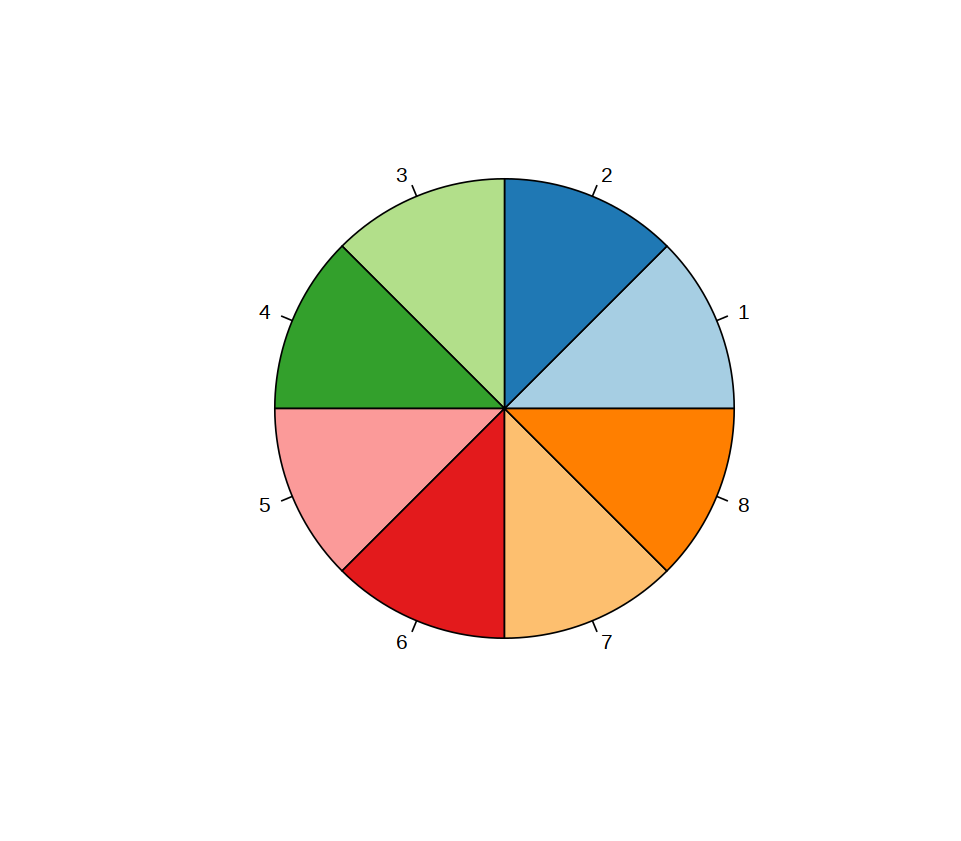

In [13]:
# make patient sample metadata and color assignments 
# http://applied-r.com/rcolorbrewer-palettes/

if (n_samples <= 4) {
    sampleColors <- brewer.pal(12, "Paired")
    sampleColors <- sampleColors[c(1,5,2,6)]
} else if (n_samples <= 12){
    sampleColors <- brewer.pal(n_samples, "Paired")
} else {
    vec_color1 <- colorRampPalette(brewer.pal(9, "Set1"))(n_samples/2)
    vec_color2 <- colorspace::lighten(vec_color1, amount=0.4) 
    sampleColors <- c(rbind(vec_color1, vec_color2))
}

sampleColors
length(sampleColors)

options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1,n_samples), col=sampleColors) 


### epi

[1] "Epithelial cells" "Epi. Non-tumor"   "LEp_prog"         "LEp_secretory"   
 [5] "LEp"              "LEp_hormone"      "BEp"              "BEp_MaSCs"       
 [9] "BEp_myo"          "Epi. Unassigned"  "Epi. Tumor"       "Normal-like"     
[13] "NBL"              "Basal"            "CLow"             "Her2E"           
[17] "LumA"             "LumB"             "Keratinocytes"

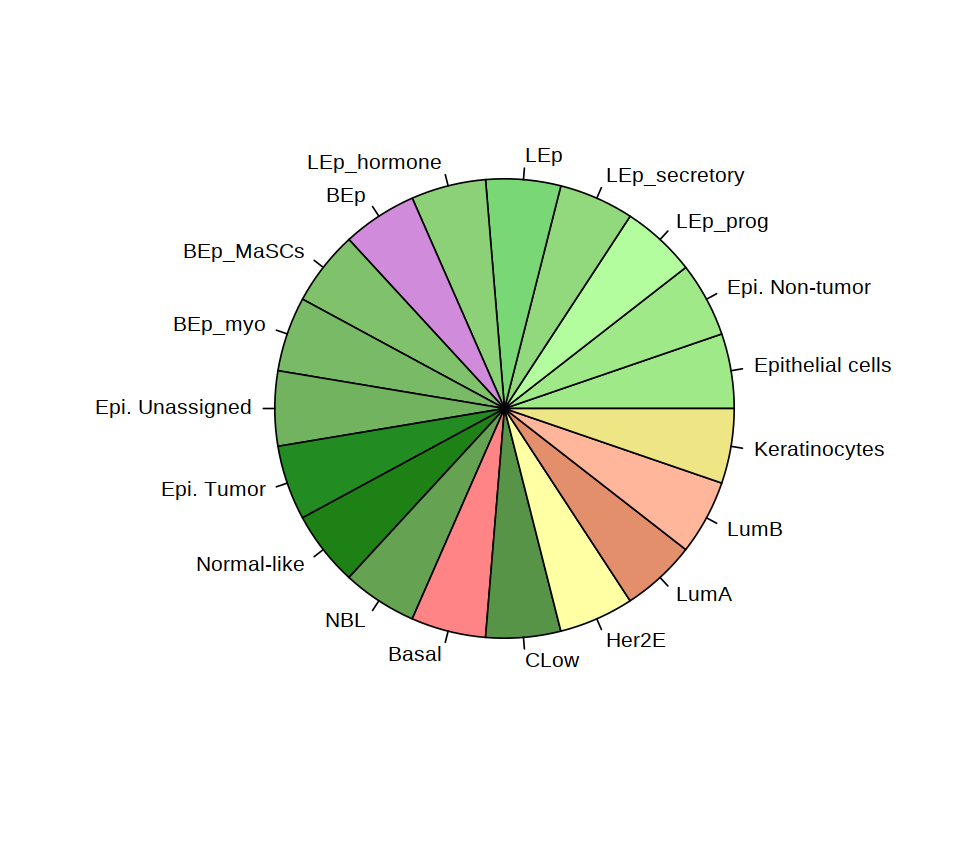

In [14]:
idx_epi <- grep(pattern_epi, names(nv_color))
names(nv_color)[idx_epi]
# http://applied-r.com/rcolorbrewer-palettes/
colors_epi <- RColorBrewer::brewer.pal(9, "Set1")
colors_epi <- colorspace::lighten(colors_epi, amount=0.4)

nv_color["Epi. Tumor"] <- "forestgreen"

nv_color["LEp_prog"] <- "#b4fd9e"
nv_color["LEp"] <- colors_epi[3]
nv_color["BEp"] <- colors_epi[4]

nv_color["Basal"] <- colors_epi[1]
nv_color["Her2E"] <- colors_epi[6]
nv_color["Her2"] <- colors_epi[6]
nv_color["LumA"] <- colors_epi[7]
nv_color["LumB"] <- colors_epi[5]
nv_color["Normal-like"] <- colorspace::darken(colors_epi[3], amount=0.4)

pie(rep(1, length(idx_epi)), col=nv_color[idx_epi],
       labels=names(nv_color)[idx_epi]) 


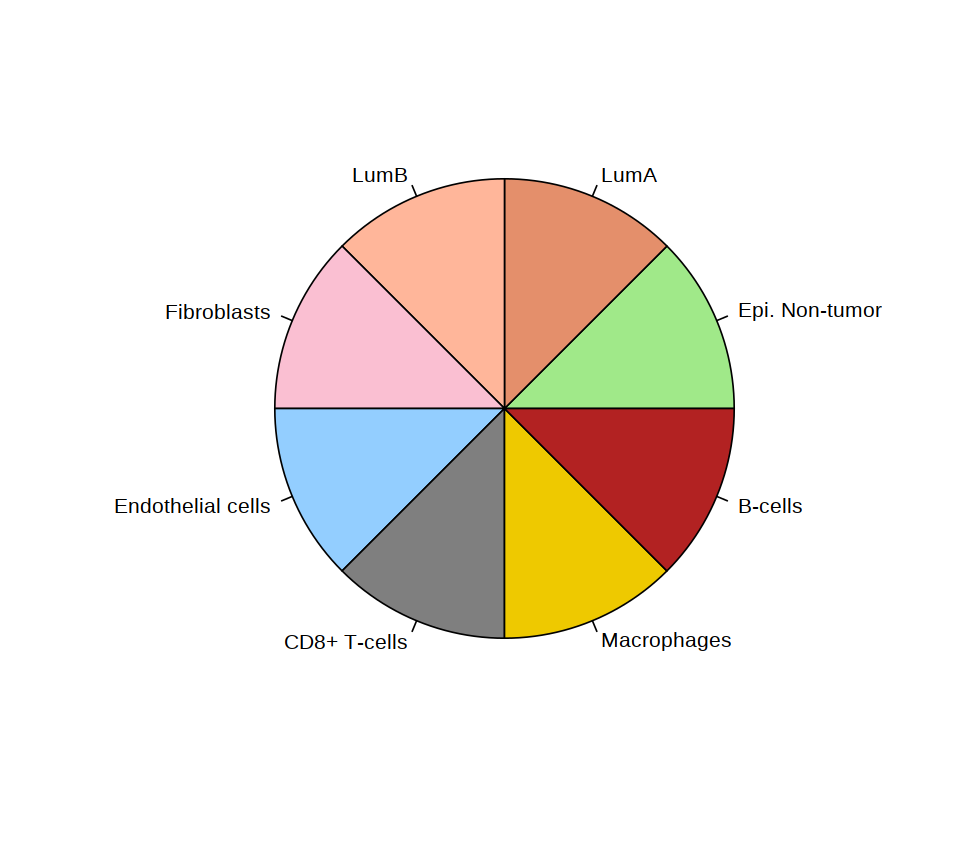

In [15]:
list_sort <- update_nv_color_cell_type(list_sort)
colors_epi <- list_sort$nv_color_cell_type

pie(rep(1, length(colors_epi)), col=colors_epi,
       labels=names(colors_epi)) 


### cell.type

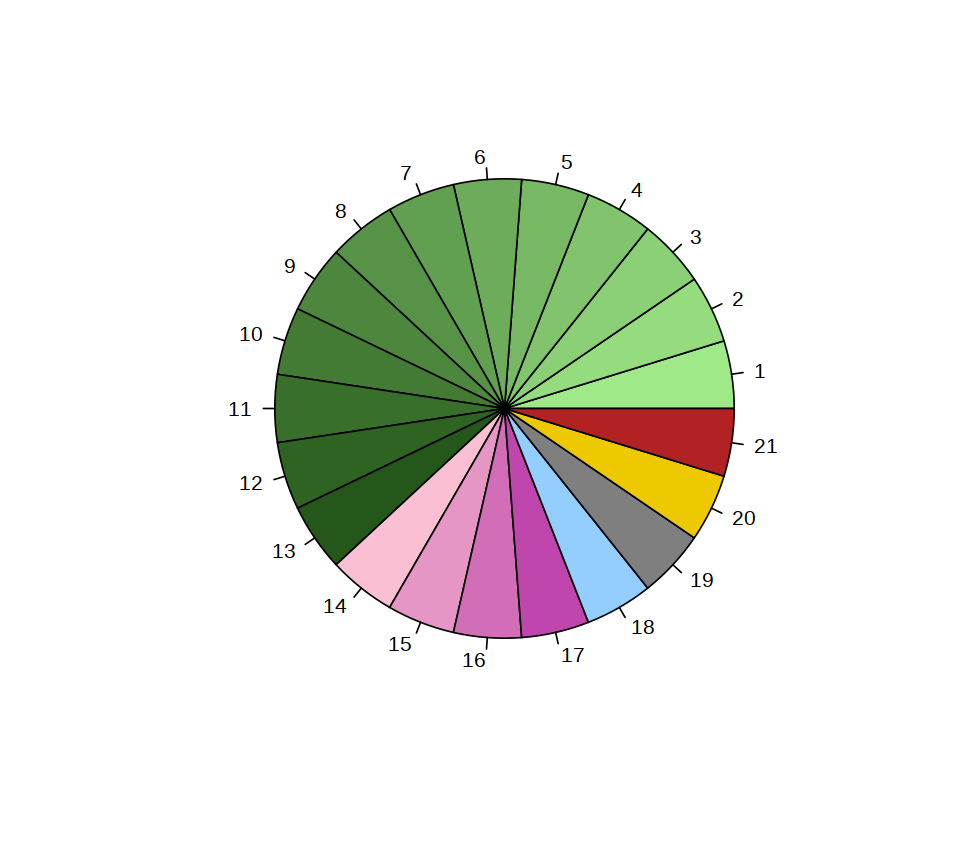

In [16]:
options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1, length(list_sort$nv_color_cluster_type_ordered)),
    col=list_sort$nv_color_cluster_type_ordered) 


# DGE

## gmt

In [17]:

list_gmt <- list()
list_gmt[["h"]] <- read.gmt("reference/gmt/h.all.v6.1.symbols.gmt")
list_gmt[["unc_lccc"]] <- read.gmt("reference/gmt/unc_lccc_human_gene_signatures.gmt")
tab_check <- "down unc_lccc"



## type_condition

In [18]:

method_dge <- "seurat_findmarkers_enricher"
dir_xlsx <- "xlsx"

list_genes_dn <- list()


# additional conditions 
genes <- NULL
str_cond1 <- NULL
str_cond_ref <- NULL
type_condition <- "none"



## all samples

In [19]:
# tumor pairs with large differences

sample1 <- NULL
sample_ref <- NULL


# for stronger signal
th_log2fc_=0.25; th_padj_=0.01

min.pct_=0.25; min.diff.pct_=-Inf; max.cells.per.ident_=Inf

f_featureplot=FALSE
n_sampling=-1
cluster_rows=FALSE

pattern_sample1 <- "Tamoxifen"
pattern_sample_ref <- NULL

drug_name <- "tamoxifen"
group_name1 <- "tamoxifen"
group_name_ref <- "control"

col_cluster_types_ <- NULL
col_cell_types_ <- "cell.type"



## find markers

In [20]:

cat(sprintf("sample1=%s\n", sample1))
cat(sprintf("sample_ref=%s\n", sample_ref))

cat(sprintf("drug_name=%s\n", drug_name))
cat(sprintf("pattern_sample1=%s\n", pattern_sample1))
cat(sprintf("pattern_sample_ref=%s\n", pattern_sample_ref))

    cat(sprintf("\t\tgroup_name1=%s\n", group_name1))
    cat(sprintf("\t\tgroup_name_ref=%s\n", group_name_ref))
    cat(sprintf("\t\tcol_cluster_types_=%s\n", col_cluster_types_))
    cat(sprintf("\t\tcol_cell_types_=%s\n", col_cell_types_))

    cat(sprintf("\t\tth_log2fc=%g\n", th_log2fc_))
    cat(sprintf("\t\tth_padj=%g\n", th_padj_))
    cat(sprintf("\t\tmin.pct=%g\n", min.pct_))
    cat(sprintf("\t\tmin.diff.pct=%g\n", min.diff.pct_))
    cat(sprintf("\t\tmax.cells.per.ident=%g\n", max.cells.per.ident_))
    cat(sprintf("\t\tmethod_dge=%s\n", method_dge))

    cat(sprintf("\t\ttype_condition=%s\n", type_condition))
    cat(sprintf("\t\tgenes=%s\n", paste(genes, collapse=", ")))
    cat(sprintf("\t\tstr_cond1=%s\n", str_cond1))
    cat(sprintf("\t\tstr_cond_ref=%s\n", str_cond_ref))



drug_name=tamoxifen
pattern_sample1=Tamoxifen
		group_name1=tamoxifen
		group_name_ref=control
		col_cell_types_=cell.type
		th_log2fc=0.25
		th_padj=0.01
		min.pct=0.25
		min.diff.pct=-Inf
		max.cells.per.ident=Inf
		method_dge=seurat_findmarkers_enricher
		type_condition=none
		genes=


seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SESN2,0,0.6681047,0.610,0.288,0,-0.1169485,0.5391669,2.704232
TMED5,0,0.6176689,0.824,0.584,0,0.0000000,0.8132268,2.698902
SARS,0,0.6518347,0.917,0.829,0,0.0000000,1.1876536,2.720065
SSR2,0,0.8573529,0.976,0.917,0,-0.3436462,1.6006364,3.030535
ATF3,0,0.6660679,0.747,0.418,0,-0.1826900,0.9567760,4.614808
PDIA6,0,0.7347166,0.919,0.801,0,-0.1262631,1.1872427,2.922513


[1] 405   8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MRPL20,0,-0.6787331,0.794,0.961,0,0.00000000,0.8534090,2.497508
PARK7,0,-0.4763361,0.961,0.989,0,0.00000000,1.5470501,2.736451
MINOS1,0,-0.5508128,0.823,0.942,0,-0.05904406,0.7932861,2.326069
NDUFS5,0,-0.5098272,0.962,0.979,0,0.00000000,1.6670255,3.051199
CITED4,0,-1.0731891,0.551,0.789,0,0.00000000,0.6689357,3.922785
PRDX1,0,-0.5639433,0.987,0.997,0,-0.06218438,2.1686562,4.273586


[1] 428   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,33/167,113/4386,1.716740e-21,7.897003e-20,6.144121e-20,ATF3/PDIA6/MTHFD2/SERP1/DNAJB9/HSPA5/HYOU1/HSP90B1/DNAJC3/HERPUD1/CALR/CEBPG/ATF4/ASNS/SSR1/HSPA9/DDIT4/EIF4EBP1/SRPRB/DDX10/EIF2AK3/IARS/CKS1B/SEC31A/VEGFA/CHAC1/WIPI1/TSPYL2/TARS/XPOT/CEBPB/SPCS3/FKBP14,33
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,41/167,200/4386,2.787540e-20,6.411342e-19,4.988230e-19,MTHFD2/SERP1/HMGCS1/CANX/SQSTM1/TCEA1/SQLE/HSPA5/IDI1/DDIT3/HSP90B1/NUPR1/TRIB3/CALR/SDF2L1/HMGCR/INSIG1/ASNS/SLC7A11/EIF2S2/SSR1/HSPA9/DDIT4/PPP1R15A/EPRS/PHGDH/LDLR/TXNRD1/FKBP2/GOT1/SCD/FAM129A/RPN1/DHCR7/UFM1/IFRD1/USO1/SHMT2/SLC6A6/GCLC/EBP,41
HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,19/167,96/4386,1.724963e-09,2.644944e-08,2.057851e-08,GOLGA4/SEC24D/LMAN1/COPE/ARFGAP3/ARF1/TMED10/SEC31A/COPB2/RAB5A/BET1/TMED2/ARCN1/USO1/SEC22B/RAB9A/DST/NAPA/COPB1,19
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,15/167,74/4386,7.059290e-08,8.118184e-07,6.316207e-07,ATF3/HMGCS1/SQLE/IDI1/TRIB3/HMGCR/STX5/LDLR/SCD/FAM129A/FDPS/DHCR7/PNRC1/FDFT1/EBP,15
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,23/167,200/4386,1.335536e-06,1.228693e-05,9.559626e-06,ATF3/SQSTM1/BTG1/EIF1/PPP1R15A/LDLR/GEM/VEGFA/CD44/JUN/HBEGF/PNRC1/TGIF1/CEBPB/NFE2L2/KLF6/MYC/GADD45A/TSC22D1/DUSP1/NFKBIA/TRIB1/IRF1,23
HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,20/167,200/4386,5.597130e-05,4.291133e-04,3.338639e-04,ATF3/HSPA5/DDIT3/BTG1/MT2A/MT1E/HMOX1/DDIT4/PPP1R15A/KLHL24/VEGFA/JUN/HDLBP/BNIP3L/PNRC1/ZNF292/KLF6/SLC6A6/NEDD4L/DUSP1,20


[1] 10  9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,55/394,430/19993,8.366493e-29,2.627079e-26,1.946310e-26,TMED5/GFPT1/MTHFD2/SERP1/SEC24D/KDELR2/SEC61G/DNAJB9/TMEM258/IDI1/HSP90B1/ARFGAP3/HSPA13/MAP1LC3B/RSL24D1/EIF2AK3/TXNRD1/SRP19/MAPK6/SEC61B/ARL1/ACBD3/MCFD2/COPB2/SUCO/TMEM39A/JMJD1C/GHITM/ARL8B/TDG/GOLT1B/CSGALNACT2/UFM1/BET1/TCEAL9/CYCS/ARCN1/SRP54/TARS/CHMP2B/XPOT/USO1/SARAF/SEC22B/RAB9A/SPCS3/CALCOCO2/SLK/EIF5/CCPG1/PRELID3B/NRBF2/TMEM106B/COPB1/ABHD5,55
Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,16/394,27/19993,4.090994e-21,6.422861e-19,4.758472e-19,DNAJB9/SLC3A2/HYOU1/SLC38A2/HERPUD1/SDF2L1/DDIT4/MAP1LC3B/EPRS/SEL1L/HBP1/CALU/KLHL24/IFRD1/CLIC4/TMEM106B,16
UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,35/394,335/19993,7.969330e-16,8.341232e-14,6.179726e-14,ARF4/CANX/TRAM1/TMCO3/PDIA3/PPIB/P4HB/LMAN1/JUND/SSR1/ARF1/PSAP/PJA2/PGM3/MAP1LC3B/SRPRA/STX3/CALU/SCD/MBNL2/CDV3/NEU1/RAB5A/GCLM/YIPF5/DNAJC10/TMED2/CLIC4/RAB9A/CDYL/TRIM27/NFE2L2/KLF6/TKT/PPIF,35
UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,13/394,29/19993,2.833810e-15,2.224541e-13,1.648084e-13,TMED9/KDELR2/PDIA3/PPIB/SEC61A1/CKAP4/SRPRB/SLC39A7/RPN1/COPB2/COPG1/GORASP2/RABAC1,13
GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,31/394,290/19993,2.029212e-14,1.274345e-12,9.441177e-13,ATF3/SERP1/SEC24D/DNAJB9/HSPA5/SLC3A2/DDIT3/PDIA3/HERPUD1/TRIB3/CALR/CEBPG/ATF4/SLC7A11/HMOX1/HSPA9/PPP1R15A/PDIA4/CRELD2/CD44/CHAC1/CEBPB/SLC38A1/SHMT2/EIF5/CCPG1/DESI2/MYC/TIMM44/GADD45A/PPIF,31
Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,26/394,281/19993,7.163645e-11,3.748974e-09,2.777484e-09,SQLE/SLC38A2/BTG1/HMGCR/DDIT4/STX3/LDLR/SEC31A/MAPK6/GOLGA2/VEGFA/ACBD3/CD44/ARL8B/BNIP3L/ATXN1/CEBPB/CDYL/DST/KLF6/DUSP10/GCLC/GADD45A/TSC22D1/NFKBIA/TRIB1,26


[1] 58  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,41/203,200/4386,6.032917e-17,2.895800e-15,2.667184e-15,SRSF7/HSPE1/PPIA/LDHA/NME1/SNRPD1/PSMA7/SRSF3/NDUFAB1/PSMB3/SNRPD3/RAN/CCT3/COX5A/PSMB2/RPS2/SRSF2/LSM2/CCT2/SSBP1/UBE2L3/SNRPD2/RANBP1/HNRNPA2B1/PSMA4/C1QBP/PSMA2/ERH/PHB/VDAC3/HNRNPD/SNRPG/XPO1/NHP2/PSMA1/PGK1/SET/SSB/LSM7/SRPK1/FAM120A,41
HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,37/203,200/4386,7.934793e-14,1.904350e-12,1.754007e-12,NDUFB3/ATP6V0E1/NDUFA4/LDHA/NDUFC2/NDUFV2/NDUFS6/NDUFAB1/COX6C/COX6B1/TIMM8B/COX5A/CYB5A/NDUFB7/NDUFB4/UQCRH/COX7A2/COX5B/UQCRQ/NDUFB6/VDAC3/NDUFC1/UQCR10/ATP1B1/SDHC/UQCR11/NDUFB8/NDUFA2/NDUFB2/POLR2F/MRPL15/NDUFB1/ECHS1/HSD17B10/TIMM10/MRPL34/MGST3,37
HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,21/203,200/4386,3.034035e-04,4.854456e-03,4.471210e-03,PPIA/TXN/LDHA/TPI1/CYB5A/FKBP4/ENO1/MIF/TSTA3/EGLN3/SDHC/PGLS/PGK1/POLR3K/TALDO1/IL13RA1/ELF3/SOX9/IER3/CLDN3/TFF3,21


[1] 3 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,35/410,107/19993,9.798750e-33,3.311977e-30,2.382643e-30,SRSF7/ATP5MC3/LDHA/NDUFC2/DYNLL1/HSP90AA1/KRT19/JPT1/CCT3/FKBP4/ENO1/RUNX1/CCT2/MARCKSL1/SNRPB/HNRNPA2B1/TRPS1/SFPQ/PSMA2/ERH/HNRNPM/VDAC3/TUBB4B/DEGS2/IGFBP4/MRPL22/TMBIM4/NDUFB8/REEP5/TSFM/MRPL13/GOLM1/CALM2/SLC40A1/PRLR,35
GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,40/410,277/19993,1.792887e-22,3.029978e-20,2.179773e-20,CITED4/TACSTD2/S100A11/VAMP8/KRT7/KRT8/KRT18/KRT19/HSPB1/CD9/FXYD3/CD24/SQOR/TSPAN15/GATA3/RER1/NDUFB9/ARHGDIB/BATF/ATP1B1/TM4SF1/SMIM22/TMEM165/CEACAM6/MRPL13/TFF1/ZG16B/TMC5/SLC9A3R1/CLDN7/ELF3/KRT80/SCGB2A2/SERHL2/XBP1/EDN1/ADIRF/CLDN3/RHOV/TFF3,40
MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,17/410,38/19993,2.801561e-19,3.156425e-17,2.270739e-17,TXN/DYNLL1/POMP/TIMM8B/LSM5/TMA7/COX7A2/COX5B/UQCRQ/GEMIN6/NDUFC1/MRPL22/UQCR11/NDUFB2/NDUFB1/ORMDL2/TIMM10,17
UNC_HS_Green25_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green25_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green25_BMC.Med.Genomics.2011_PMID.21214954,11/410,24/19993,4.638975e-13,3.450834e-11,2.482537e-11,GATA3/PIP/TFF1/TMC5/TFAP2B/SCGB2A2/XBP1/DUSP4/ADIRF/SCGB1D2/TFF3,11
UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,31/410,314/19993,5.104784e-13,3.450834e-11,2.482537e-11,CCND1/KRT18/KRT19/CYB5A/TSPAN15/GATA3/MUC1/EGLN3/IGFBP4/TMBIM4/REEP5/PIP/CEACAM6/EMP2/TFF1/EVA1B/SCGB2A1/ORMDL2/SYNGR2/TMC5/SLC9A3R1/RARRES3/TFAP2B/SCGB2A2/XBP1/AHNAK/DUSP4/ADIRF/SCGB1D2/GSTM3/TFF3,31
Duke_Module13_myc_Mike_PMID.20335537,Duke_Module13_myc_Mike_PMID.20335537,Duke_Module13_myc_Mike_PMID.20335537,29/410,326/19993,3.823874e-11,2.098135e-09,1.509403e-09,SRSF7/KRT18/NME1/JPT1/SNRPD1/RAN/CCT3/HSPA8/FKBP4/ENO1/SRSF2/CCT2/SNRPB/RANBP1/C1QBP/COA4/PHB/MAT2A/HNRNPM/UBE2N/MRPL3/SET/MRPL15/SSB/HSD17B10/OLA1/EEF1E1/RRS1/IMP3,29


[1] 71  9

filename_xlsx: xlsx/er+bc-pairs_control_vs_tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc-pairs_control_vs_tamoxifen_Tumor_cells_zscore

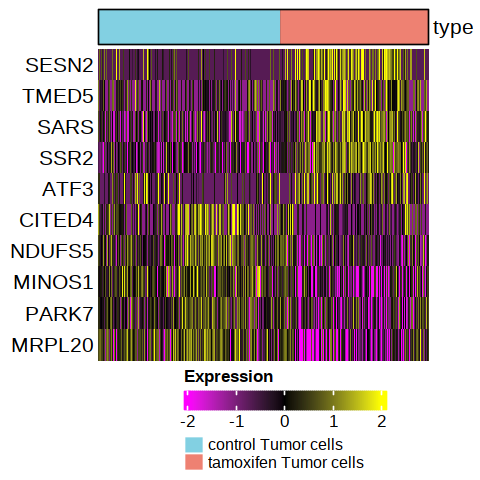

In [21]:

list_markers <- find_markers(rna, sample1 = sample1,
                        sample_ref = sample_ref,
                        pattern_sample1 = pattern_sample1,
                        pattern_sample_ref = pattern_sample_ref,
                             
                        # pattern_tumor_epi     
                        pattern_cell_type1 = pattern_tumor_epi,
                        pattern_cell_type_ref = pattern_tumor_epi,
                             
                        genes = genes,
                        str_cond1 = str_cond1,
                        str_cond_ref = str_cond_ref,
                             
                        group_name1 = sprintf("%s Tumor cells", group_name1),
                        group_name_ref = sprintf("%s Tumor cells", group_name_ref),
                        col_cluster_types = col_cluster_types_,
                        col_cell_types = col_cell_types_,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_, 
                        min.pct = min.pct_,
                        min.diff.pct = min.diff.pct_,
                        max.cells.per.ident = max.cells.per.ident_,
                        method_dge = method_dge)

str_condition_tmp <- sprintf("%s_%s_vs_%s_Tumor cells",
                             str_condition,
                             group_name_ref, group_name1)

if (type_condition != "none") {
          str_condition_tmp <- sprintf("%s_%s", str_condition_tmp, type_condition)
}

list_ea <- execute_enrichment_analysis(list_markers$markers,
                        str_condition_tmp,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_,
                        method_dge = method_dge,
                        dir_xlsx = dir_xlsx,       
                        n_log = 1)


genes_up <- rownames(list_ea$df_up)
genes_dn <- rownames(list_ea$df_dn)
list_genes_dn[["Epi"]] <- genes_dn

if (f_featureplot) {
    gg <- featureplot_enrichment_analysis(rna,
                list_ea,
                str_condition_tmp)
}

list_out_heatmap <- heatmap_enrichment_analysis(list_markers,
                    list_ea,
                    str_condition_tmp,
                    pattern_gene_removal="^MT-|^RPS|^RPL",
                    max_up=5, max_dn=5,
                    n_sampling=n_sampling,
                    cluster_rows=cluster_rows)



# session info

In [22]:
writeLines(capture.output(sessionInfo()), "txt/sessionInfo.txt")


# reference

https://satijalab.org/seurat/

